## 0. Modules and Functions

### Functions
- parse_add(addtional_part_of_gencode)
- sam_to_table(sam_file_code)
- read_specific_transcript(sam_file_code, transcript)
- read_from_trx_ser(sam_file_code, filtered_trx_series)

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def parse_add(add):
    ret_dict = {'transcript_id':'NaN'}
    valid = ['gene_id','transcript_id','gene_type','gene_name','level']
    for row in add.split(';'):
        kv_pair = row.split()
        if len(kv_pair)<=1 : continue
        if kv_pair[0] in valid:
            ret_dict[kv_pair[0]]=kv_pair[1]
    return [val.replace('"','') for val in ret_dict.values()]

In [3]:
def sam_to_table(code):
    read_table = defaultdict(int)
    with open(f"{code}/Aligned.out.sam") as inpfile:
        for line in inpfile:
            if line.startswith('@'): continue # header 제거
        
            line_list = line.split()
            if line_list[1]==4 or line_list[1]==16: continue # 잘못 read된 data 제거
        
            if line_list[2].startswith('ENSMUST'):
                read_table[line_list[2].split('|')[0]]+=1
            
    table_df = pd.Series(read_table)
    return table_df[table_df>= 30] # 30 read 보다 작은 경우는 filter

In [4]:
def read_specific_transcript(code, trans):
    read_table = defaultdict(int)
    with open(f"{code}/Aligned.out.sam") as inpfile:
        for line in inpfile:
            if line.startswith('@'): continue # header 제거
            
            line_list = line.split()
            if line_list[1]==4: continue # 잘못 read된 data 제거
        
            if line_list[2].startswith(trans):
                read_table[int(line_list[3])]+=1
            
    table_df = pd.Series(read_table)
    return table_df

In [17]:
def read_from_trx_ser(code, trx_ser_idx):
    read_table = []
    with open(f"{code}/Aligned.out.sam") as inpfile:
        for line in inpfile:
            if line.startswith('@'): continue # header 제거
            
            line_list = line.split()
            if line_list[1]==4: continue # 잘못 read된 data 제거
        
            if line_list[2].startswith('ENSMUST'):
                if line_list[2].split('|')[0] in trx_ser_idx:
                    read_table.append([line_list[2].split('|')[0], int(line_list[3]), 1])
            
    table_df = pd.DataFrame(read_table)
    table_df.columns = ['trx', 'pos', 'cnt']
    return table_df

## 1.GTF File Parsing

### Informations we need
- column 3 : feature type
- column 4 : genomic start loc
- column 5 : genomic end loc
- column 7 : genomic strand(+/-)
- column 9 : additional info
    - gene_id
    - transcript_id
    - gene_type
    - level
    
### Filtering
- non coding genes
- gene level not 1
- (+) strand

In [5]:
path = "/home/qbio1/kangjunseo/tutorials/ref_gene/gencode.vM29.primary_assembly.annotation.gtf"

In [6]:
GTF_df = pd.read_csv(path, header=5, delimiter='\t')
GTF_df.columns=['chr','ann','feature','start','end','score','strand','phase','add']
GTF_df.head()

,chr,ann,feature,start,end,score,strand,phase,add
0,chr1,HAVANA,transcript,3143476,3144545,.,+,.,"gene_id ""ENSMUSG00000102693.2""; transcript_id ..."
1,chr1,HAVANA,exon,3143476,3144545,.,+,.,"gene_id ""ENSMUSG00000102693.2""; transcript_id ..."
2,chr1,ENSEMBL,gene,3172239,3172348,.,+,.,"gene_id ""ENSMUSG00000064842.3""; gene_type ""snR..."
3,chr1,ENSEMBL,transcript,3172239,3172348,.,+,.,"gene_id ""ENSMUSG00000064842.3""; transcript_id ..."
4,chr1,ENSEMBL,exon,3172239,3172348,.,+,.,"gene_id ""ENSMUSG00000064842.3""; transcript_id ..."


In [7]:
GTF_df_compact = GTF_df.drop(columns=['chr','ann','score','phase'])
GTF_df_compact.head()

,feature,start,end,strand,add
0,transcript,3143476,3144545,+,"gene_id ""ENSMUSG00000102693.2""; transcript_id ..."
1,exon,3143476,3144545,+,"gene_id ""ENSMUSG00000102693.2""; transcript_id ..."
2,gene,3172239,3172348,+,"gene_id ""ENSMUSG00000064842.3""; gene_type ""snR..."
3,transcript,3172239,3172348,+,"gene_id ""ENSMUSG00000064842.3""; transcript_id ..."
4,exon,3172239,3172348,+,"gene_id ""ENSMUSG00000064842.3""; transcript_id ..."


In [8]:
add_table = []
for row in GTF_df['add']:
    add_table.append(parse_add(row))
add_df = pd.DataFrame(add_table)
add_df.head()

,0,1,2,3,4
0,ENSMUST00000193812.2,ENSMUSG00000102693.2,TEC,4933401J01Rik,2
1,ENSMUST00000193812.2,ENSMUSG00000102693.2,TEC,4933401J01Rik,2
2,NaN,ENSMUSG00000064842.3,snRNA,Gm26206,3
3,ENSMUST00000082908.3,ENSMUSG00000064842.3,snRNA,Gm26206,3
4,ENSMUST00000082908.3,ENSMUSG00000064842.3,snRNA,Gm26206,3


In [9]:
GTF_df2_untrimmed = pd.concat([GTF_df_compact,add_df], axis=1)
GTF_df2_untrimmed = GTF_df2_untrimmed.drop(columns=['add'])
GTF_df2_untrimmed.columns = ['feature','start','end','strand','transcript_id','gene_id','gene_type','gene_name','level']
GTF_df2_untrimmed.head()

,feature,start,end,strand,transcript_id,gene_id,gene_type,gene_name,level
0,transcript,3143476,3144545,+,ENSMUST00000193812.2,ENSMUSG00000102693.2,TEC,4933401J01Rik,2
1,exon,3143476,3144545,+,ENSMUST00000193812.2,ENSMUSG00000102693.2,TEC,4933401J01Rik,2
2,gene,3172239,3172348,+,NaN,ENSMUSG00000064842.3,snRNA,Gm26206,3
3,transcript,3172239,3172348,+,ENSMUST00000082908.3,ENSMUSG00000064842.3,snRNA,Gm26206,3
4,exon,3172239,3172348,+,ENSMUST00000082908.3,ENSMUSG00000064842.3,snRNA,Gm26206,3


In [10]:
GTF_df2 = GTF_df2_untrimmed[GTF_df2_untrimmed['gene_type']=='protein_coding']
#GTF_df2 = GTF_df2[(GTF_df2['level']=='1')|(GTF_df2['level']=='2')]
GTF_df2['length'] = GTF_df2['end']-GTF_df2['start']+1

/tmp/ipykernel_867910/3454634102.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GTF_df2['length'] = GTF_df2['end']-GTF_df2['start']+1


In [11]:
GTF_df2_plus = GTF_df2[GTF_df2['strand']=='+']
GTF_df2_plus.head(30)

,feature,start,end,strand,transcript_id,gene_id,gene_type,gene_name,level,length
354,gene,4878011,4918633,+,NaN,ENSMUSG00000025903.15,protein_coding,Lypla1,2,40623
355,transcript,4878011,4918633,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,40623
356,exon,4878011,4878205,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,195
357,CDS,4878137,4878205,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,69
358,start_codon,4878137,4878139,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,3
359,exon,4878678,4878709,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,32
360,CDS,4878678,4878709,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,32
361,exon,4898807,4898872,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,66
362,CDS,4898807,4898872,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,66
363,exon,4900491,4900538,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,48


In [12]:
GTF_df2_plus_CDS = GTF_df2_plus[GTF_df2_plus['feature']=='CDS']
GTF_df2_plus_CDS.head()

,feature,start,end,strand,transcript_id,gene_id,gene_type,gene_name,level,length
357,CDS,4878137,4878205,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,69
360,CDS,4878678,4878709,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,32
362,CDS,4898807,4898872,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,66
364,CDS,4900491,4900538,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,48
366,CDS,4902534,4902604,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,71


In [13]:
trx_ser = GTF_df2_plus_CDS[['transcript_id','length','gene_id']].groupby(by=['transcript_id','gene_id']).sum().sort_values(by=['length'], ascending=False)
trx_ser

,,length
transcript_id,gene_id,
ENSMUST00000183034.5,ENSMUSG00000026131.21,23151
ENSMUST00000239545.1,ENSMUSG00000118670.1,22572
ENSMUST00000115104.10,ENSMUSG00000026131.21,22218
ENSMUST00000097785.10,ENSMUSG00000026131.21,22179
ENSMUST00000143764.9,ENSMUSG00000075249.13,20985
...,...,...
ENSMUST00000202527.4,ENSMUSG00000023033.15,3
ENSMUST00000202071.2,ENSMUSG00000023033.15,3
ENSMUST00000200933.4,ENSMUSG00000023033.15,3


## 2. Figure S5A (1 gene)

In [15]:
table = sam_to_table("RPF_siLin28a").sort_values(ascending=False)
table.head()

ENSMUST00000240377.1     1007005
ENSMUST00000082402.1       13957
ENSMUST00000027752.15      12497
ENSMUST00000055226.13       8926
ENSMUST00000020238.14       8925
dtype: int64

In [17]:
table2 = sam_to_table("RPF_siLuc").sort_values(ascending=False)
table2.head()

In [ ]:
RST = read_specific_transcript("RPF_siLin28a","ENSMUST00000082402.1").sort_index()
RST.plot()

In [ ]:
RST = read_specific_transcript("RPF_siLuc","ENSMUST00000082402.1").sort_index()
RST.plot()

In [ ]:
one_gene_df = GTF_df2_untrimmed[GTF_df2_untrimmed['transcript_id']=="ENSMUST00000082402.1"]
one_gene_df.head()

In [ ]:
plt.bar(RST.index, RST.values, color='k', zorder=10)
plt.axvline(0, color='r', zorder=5)
plt.xlim(-50,51)
plt.ylim(0,100)

In [ ]:
end = 6869-5328+1
plt.bar(RST.index, RST.values, color='k', zorder=10)
plt.axvline(end, color='r', zorder=5)
plt.xlim(end-50, end+51)
plt.ylim(0,100)

## 3. Figure S5A (coding genes)

In [14]:
trx_ser['gene'] = [g for t, g in trx_ser.index]
trx_ser.index = [t for t,g in trx_ser.index]
trx_ser

,length,gene
ENSMUST00000183034.5,23151,ENSMUSG00000026131.21
ENSMUST00000239545.1,22572,ENSMUSG00000118670.1
ENSMUST00000115104.10,22218,ENSMUSG00000026131.21
ENSMUST00000097785.10,22179,ENSMUSG00000026131.21
ENSMUST00000143764.9,20985,ENSMUSG00000075249.13
...,...,...
ENSMUST00000202527.4,3,ENSMUSG00000023033.15
ENSMUST00000202071.2,3,ENSMUSG00000023033.15
ENSMUST00000200933.4,3,ENSMUSG00000023033.15
ENSMUST00000201484.4,3,ENSMUSG00000023033.15


In [15]:
trx_ser_best = trx_ser.drop_duplicates('gene') # longest isoform만 남기기
trx_ser_best

,length,gene
ENSMUST00000183034.5,23151,ENSMUSG00000026131.21
ENSMUST00000239545.1,22572,ENSMUSG00000118670.1
ENSMUST00000143764.9,20985,ENSMUSG00000075249.13
ENSMUST00000044217.16,20622,ENSMUSG00000063450.15
ENSMUST00000212287.2,17424,ENSMUSG00000040838.11
...,...,...
ENSMUST00000166681.2,48,ENSMUSG00000092004.2
ENSMUST00000168858.2,45,ENSMUSG00000079333.4
ENSMUST00000165358.2,45,ENSMUSG00000091109.2
ENSMUST00000179793.2,24,ENSMUSG00000095386.2


In [18]:
CDS_read = read_from_trx_ser("alignment/RPF_siLin28a", trx_ser_best.index)
CDS_read.head()

,trx,pos,cnt
0,ENSMUST00000116560.3,317,1
1,ENSMUST00000077271.9,1382,1
2,ENSMUST00000190686.7,1105,1
3,ENSMUST00000046404.8,455,1
4,ENSMUST00000105105.4,37,1


In [19]:
utrs = GTF_df2[GTF_df2['feature']=='UTR']
utr_map = utrs[['transcript_id','start','end']].groupby(by=['transcript_id']).min()
utr_map['length'] = utr_map['end'] - utr_map['start'] + 1
utr_map.sort_values(by=['length'], ascending=False)

,start,end,length
transcript_id,,,
ENSMUST00000053033.14,97534043,97573442,39400
ENSMUST00000233317.2,85851232,85874416,23185
ENSMUST00000232701.2,12296778,12316373,19596
ENSMUST00000053880.13,135690231,135709098,18868
ENSMUST00000233892.2,12296778,12315399,18622
...,...,...,...
ENSMUST00000128420.9,46451264,46451264,1
ENSMUST00000212277.2,70388686,70388686,1
ENSMUST00000198126.2,138148942,138148942,1


In [20]:
CDS_np = CDS_read.to_numpy()
for row in CDS_np:
    try:
        row[1] -= utr_map['length'][row[0]]
    except:
        pass
CDS_np

array([['ENSMUST00000116560.3', 202, 1],
       ['ENSMUST00000077271.9', 1239, 1],
       ['ENSMUST00000190686.7', 893, 1],
       ...,
       ['ENSMUST00000082402.1', 61, 1],
       ['ENSMUST00000056449.9', 800, 1],
       ['ENSMUST00000171332.2', 12744, 1]], dtype=object)

In [21]:
CDS_read_start = pd.DataFrame(CDS_np)
CDS_read_start.columns = ['trx','pos','cnt']
read_count = CDS_read_start[['pos','cnt']].groupby(by=['pos']).sum()
read_count.head()

,cnt
pos,
-7163,1
-7162,1
-7135,1
-7111,1
-7047,1


(0.0, 12000.0)

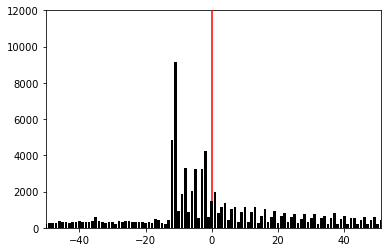

In [22]:
plt.bar(list(map(int, read_count.index)), list(map(int, read_count.values)), color='k', zorder=10)
plt.axvline(0, color='r', zorder=5)
plt.xlim(-50,51)
plt.ylim(0,12000)

In [22]:
CDS_np2 = CDS_read.to_numpy()
for row in CDS_np2:
    row[1] -= trx_ser_best['length'][row[0]]
    try:
        row[1] -= utr_map['length'][row[0]]
    except:
        pass
CDS_np2

array([['ENSMUST00000116560.3', -479, 1],
       ['ENSMUST00000077271.9', -1014, 1],
       ['ENSMUST00000190686.7', -7216, 1],
       ...,
       ['ENSMUST00000082402.1', -1481, 1],
       ['ENSMUST00000056449.9', -2479, 1],
       ['ENSMUST00000171332.2', -405, 1]], dtype=object)

In [37]:
CDS_read_end = pd.DataFrame(CDS_np2)
CDS_read_end.columns = ['trx','pos','cnt']

In [31]:
CDS_read_end[CDS_read_end['pos']>=0][['pos','cnt']].groupby(by=['pos']).sum().sort_values(by=['cnt'],ascending=False)

,cnt
pos,
382,278
381,194
390,179
387,178
548,127
...,...
1441,1
1444,1
1449,1


In [40]:
filter_list = {'ENSMUST00000038863.9'}

In [43]:
CDS_read_end = CDS_read_end[CDS_read_end['trx']!='ENSMUST00000038863.9']

In [57]:
CDS_read_end[CDS_read_end['pos']==4]

,trx,pos,cnt
3019,ENSMUST00000124665.3,4,1
7164,ENSMUST00000183663.8,4,1
8020,ENSMUST00000107462.8,4,1
8021,ENSMUST00000107462.8,4,1
15907,ENSMUST00000028880.10,4,1
...,...,...,...
560563,ENSMUST00000107462.8,4,1
564084,ENSMUST00000169082.3,4,1
566591,ENSMUST00000184603.8,4,1
583446,ENSMUST00000081335.13,4,1


In [44]:
read_count2 = CDS_read_end[['pos','cnt']].groupby(by=['pos']).sum()
read_count2.tail()

,cnt
pos,
48667,4
62460,1
112955,2
112958,1
113207,1


(0.0, 12000.0)

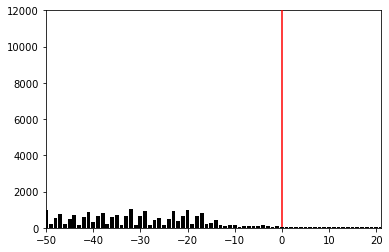

In [45]:
plt.bar(list(map(int, read_count2.index)), list(map(int, read_count2.values)), color='k', zorder=10)
plt.axvline(0, color='r', zorder=5)
plt.xlim(-50,21)
plt.ylim(0,12000)

## 4. Figure 5A (final)

### siLin28a

In [1]:
import pysam
def sam_to_df(code):
    read_table = []
    with open(f"{code}/Aligned.out.sam") as inpfile:
        for line in inpfile:
            if line.startswith('@'): continue # header 제거
            
            line_list = line.split()
            if line_list[1]==4 or line_list[1]==16: continue
            
            if line_list[2].startswith('ENSMUST'):
                add = line_list[2].split('|')
                read_table.append([line_list[0]]+add[:2]+[int(line_list[3]), 1])
            
    table_df = pd.DataFrame(read_table)
    table_df.columns = ['read','trx','gene','pos','cnt']
    
    return table_df

def bam_to_df(code):
    read_table=[]
    align = pysam.AlignmentFile(f"{code}/Aligned.out.bam", 'rb')
    
    for line in align:
        if line.is_unmapped or line.is_reverse: continue
        else: read_table.append([line.query_name, line.reference_name, line.reference_start, 1])
        
    table_df = pd.DataFrame(read_table)
    table_df.columns = ['read','trx','pos','cnt']
    return table_df

In [5]:
cnt = 0
with open("alignment/RPF_siLuc/Aligned.out.sam") as inpfile:
    for line in inpfile:
        if line.startswith('@'):
            cnt+=1
        else: break
print(cnt)

142443


In [ ]:
siLuc = pd.read_csv("alignment/RPF_siLuc/Aligned.out.sam", header=142443, delimiter='\t')
siLuc.head()

In [27]:
temp = sam_to_df("alignment/RPF_siLin28a")
temp

,read,trx,gene,pos,cnt
0,SRR458757.1013987,ENSMUST00000240377.1,ENSMUSG00000119584.1,294,1
1,SRR458757.1013992,ENSMUST00000116560.3,ENSMUSG00000056201.9,317,1
2,SRR458757.1013992,ENSMUST00000209469.2,ENSMUSG00000056201.9,347,1
3,SRR458757.1013992,ENSMUST00000237122.2,ENSMUSG00000056201.9,237,1
4,SRR458757.1013992,ENSMUST00000236645.2,ENSMUSG00000056201.9,286,1
...,...,...,...,...,...
4792300,SRR458757.1954397,ENSMUST00000135312.3,ENSMUSG00000048865.17,1113,1
4792301,SRR458757.1954397,ENSMUST00000056449.9,ENSMUSG00000048865.17,1113,1
4792302,SRR458757.1954397,ENSMUST00000131607.7,ENSMUSG00000048865.17,1553,1
4792303,SRR458757.1954398,ENSMUST00000030547.15,ENSMUSG00000028763.19,12813,1


In [27]:
del_multiread = temp.drop_duplicates(subset=['read','gene'])
del_multiread 

,read,trx,gene,pos,cnt
0,SRR458757.1013987,ENSMUST00000240377.1,ENSMUSG00000119584.1,294,1
1,SRR458757.1013992,ENSMUST00000116560.3,ENSMUSG00000056201.9,317,1
5,SRR458757.1013992,ENSMUST00000065243.9,ENSMUSG00000053038.9,202,1
6,SRR458757.1013993,ENSMUST00000240377.1,ENSMUSG00000119584.1,811,1
7,SRR458757.1013994,ENSMUST00000161009.7,ENSMUSG00000027774.17,1362,1
...,...,...,...,...,...
4792295,SRR458757.1954394,ENSMUST00000135680.8,ENSMUSG00000058267.14,265,1
4792298,SRR458757.1954395,ENSMUST00000082402.1,ENSMUSG00000064351.1,64,1
4792299,SRR458757.1954396,ENSMUST00000240377.1,ENSMUSG00000119584.1,140,1
4792300,SRR458757.1954397,ENSMUST00000135312.3,ENSMUSG00000048865.17,1113,1


In [28]:
full_filter_df = del_multiread[del_multiread['trx'].isin(trx_ser_best.index)][['trx','pos','cnt']]
full_filter_df

,trx,pos,cnt
1,ENSMUST00000116560.3,317,1
29,ENSMUST00000046404.8,455,1
49,ENSMUST00000105105.4,37,1
50,ENSMUST00000091703.3,112,1
54,ENSMUST00000049453.9,151,1
...,...,...,...
4792242,ENSMUST00000066601.13,2931,1
4792257,ENSMUST00000178310.9,155,1
4792286,ENSMUST00000005279.8,441,1
4792295,ENSMUST00000135680.8,265,1


In [29]:
ffd_np = full_filter_df.to_numpy()
for row in ffd_np:
    try:
        row[1] -= utr_map['length'][row[0]]
    except:
        pass
ffd_np

array([['ENSMUST00000116560.3', 202, 1],
       ['ENSMUST00000046404.8', 393, 1],
       ['ENSMUST00000105105.4', -2, 1],
       ...,
       ['ENSMUST00000005279.8', 137, 1],
       ['ENSMUST00000135680.8', 213, 1],
       ['ENSMUST00000082402.1', 61, 1]], dtype=object)

In [30]:
read_start = pd.DataFrame(ffd_np)
read_start.columns = ['trx','pos','cnt']
start_c = read_start[['pos','cnt']].groupby(by=['pos']).sum()
start_c.head(10)

,cnt
pos,
-6895,1
-6676,1
-6496,1
-6390,1
-6142,1
-6131,1
-6094,1
-6053,1
-6046,1


(0.0, 12000.0)

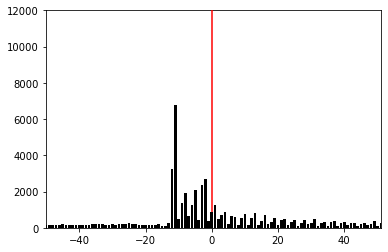

In [31]:
plt.bar(list(map(int, start_c.index)), list(map(int, start_c.values)), color='k', zorder=10)
plt.axvline(0, color='r', zorder=5)
plt.xlim(-50,51)
plt.ylim(0,12000)

(0.0, 12000.0)

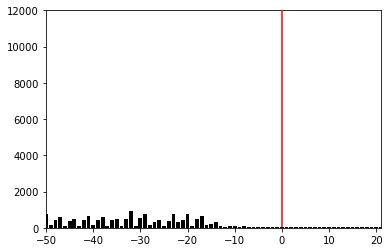

In [32]:
ffd_np2 = full_filter_df.to_numpy()
for row in ffd_np2:
    row[1] -= trx_ser_best['length'][row[0]]
    try:
        row[1] -= utr_map['length'][row[0]]
    except:
        pass
read_stop = pd.DataFrame(ffd_np2)
read_stop.columns = ['trx','pos','cnt']
stop_c = read_stop[['pos','cnt']].groupby(by=['pos']).sum()
plt.bar(list(map(int, stop_c.index)), list(map(int, stop_c.values)), color='k', zorder=10)
plt.axvline(0, color='r', zorder=5)
plt.xlim(-50,21)
plt.ylim(0,12000)

### siLuc

In [87]:
chunksize = 10**5
siLuc = pd.DataFrame()
for cnt, chunk in enumerate(pd.read_csv("alignment/RPF_siLuc/Aligned.out.sam", header=142443, sep='\t', chunksize=chunksize)):
    chunk_list = []
    
    for i in range(len(chunk)):
        tmp = chunk.iloc[i].tolist()
        if tmp[1]==4 or tmp==16: continue
            
        if tmp[2].startswith('ENSMUST'):
            add = tmp[2].split('|')
            chunk_list.append([tmp[0]]+add[:2]+[int(tmp[3]),1])
            
    chunk_df = pd.DataFrame(chunk_list)
    chunk_df.columns = ['read','trx', 'gene', 'pos', 'cnt']
    siLuc = pd.concat([siLuc, chunk_df])

    if cnt%10==0: print(cnt, end = ' ')
        
siLuc.head()

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 

,read,trx,gene,pos,cnt
0,SRR458756.658559,ENSMUST00000082390.1,ENSMUSG00000064339.1,415,1
1,SRR458756.658561,ENSMUST00000044200.11,ENSMUSG00000038279.11,224,1
2,SRR458756.658561,ENSMUST00000204185.2,ENSMUSG00000038279.11,304,1
3,SRR458756.658563,ENSMUST00000058030.10,ENSMUSG00000062937.8,809,1
4,SRR458756.658564,ENSMUST00000240377.1,ENSMUSG00000119584.1,845,1


In [89]:
#siLuc = siLuc[siLuc['add'].str.startswith('ENSMUST')]
siLuc = siLuc.drop_duplicates(subset=['read','gene'])
siLuc

,read,trx,gene,pos,cnt
0,SRR458756.658559,ENSMUST00000082390.1,ENSMUSG00000064339.1,415,1
1,SRR458756.658561,ENSMUST00000044200.11,ENSMUSG00000038279.11,224,1
3,SRR458756.658563,ENSMUST00000058030.10,ENSMUSG00000062937.8,809,1
4,SRR458756.658564,ENSMUST00000240377.1,ENSMUSG00000119584.1,845,1
5,SRR458756.658566,ENSMUST00000201932.2,ENSMUSG00000107349.2,1142,1
...,...,...,...,...,...
27525,SRR458756.21823901,ENSMUST00000102843.10,ENSMUSG00000020458.17,2217,1
27527,SRR458756.21823906,ENSMUST00000240377.1,ENSMUSG00000119584.1,850,1
27528,SRR458756.21823907,ENSMUST00000240377.1,ENSMUSG00000119584.1,851,1
27529,SRR458756.21823909,ENSMUST00000005017.15,ENSMUSG00000004897.17,994,1


In [90]:
siLuc = siLuc[siLuc['trx'].isin(trx_ser_best.index)][['trx','pos','cnt']]
siLuc

,trx,pos,cnt
1,ENSMUST00000044200.11,224,1
3,ENSMUST00000058030.10,809,1
12,ENSMUST00000141047.2,1981,1
22,ENSMUST00000085797.6,467,1
29,ENSMUST00000047057.9,383,1
...,...,...,...
27485,ENSMUST00000052248.8,171,1
27509,ENSMUST00000011400.8,1742,1
27513,ENSMUST00000110347.9,1222,1
27525,ENSMUST00000102843.10,2217,1


In [91]:
!pwd

/home/qbio1/kangjunseo/tutorials


In [92]:
siLuc.to_csv('/home/qbio1/kangjunseo/tutorials/siLuc.csv', sep='\t', na_rep='NaN')

In [93]:
siL_np = siLuc.to_numpy()
for row in siL_np:
    try:
        row[1] -= utr_map['length'][row[0]]
    except:
        pass
siL_np

array([['ENSMUST00000044200.11', 129, 1],
       ['ENSMUST00000058030.10', 439, 1],
       ['ENSMUST00000141047.2', 1473, 1],
       ...,
       ['ENSMUST00000110347.9', 967, 1],
       ['ENSMUST00000102843.10', 1975, 1],
       ['ENSMUST00000005017.15', 687, 1]], dtype=object)

In [94]:
siL_start = pd.DataFrame(siL_np)
siL_start.columns = ['trx','pos','cnt']
siL_st = siL_start[['pos','cnt']].groupby(by=['pos']).sum()
siL_st.head(10)

,cnt
pos,
-7186,2
-7185,1
-7135,1
-6994,1
-6964,1
-6949,1
-6946,1
-6938,1
-6911,1


(0.0, 60000.0)

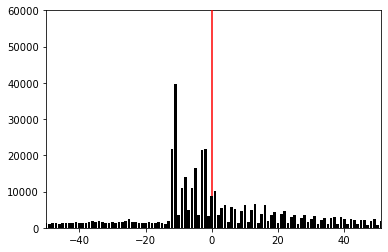

In [96]:
plt.bar(list(map(int, siL_st.index)), list(map(int, siL_st.values)), color='k', zorder=10)
plt.axvline(0, color='r', zorder=5)
plt.xlim(-50,51)
plt.ylim(0,60000)

In [ ]:
f = plt.figure(figsize=(20,3))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.bar(list(map(int, start_c.index)), list(map(int, start_c.values)), color='k', zorder=10)
ax1.axvline(0, color='r', zorder=5)
ax1.set_xlim(-50,51)
ax1.set_ylim(0,12000)

ax2.bar(list(map(int, stop_c.index)), list(map(int, stop_c.values)), color='k', zorder=10)
ax2.axvline(0, color='r', zorder=5)
ax2.set_xlim(-50,21)
ax2.set_ylim(0,12000)